In [22]:
import numpy as np
import pandas as pd

In [23]:
df=pd.read_csv('data2.csv')

## Stage 1

In [24]:
#Select only dates when atleast 2 earthquake of atleast 3.3 magnitude occured
df['Date ']=pd.to_datetime(df['Date '])
df['mag']=df['mag'].astype(float)

df1=df[df['mag']>=3.3]
df1=df1.groupby('Date ').filter(lambda x: len(x)>=2)
dates=df1['Date '].unique()

In [25]:
#Include the previous date of the selected dates in case it is not already included
dates=pd.to_datetime(dates)
dates=dates-pd.DateOffset(1)
dates=dates.strftime('%Y-%m-%d')
dates=pd.to_datetime(dates)
dates=dates.union(df1['Date '].unique())
dates=dates.sort_values()

In [26]:
df=df[df['Date '].isin(dates)]

## Stage 2

In [27]:
dates=df['Date '].unique()

In [28]:
#For each date calculate the centroid
centroids=[]
for date in dates:
    df1=df[df['Date ']==date]
    lat=np.mean(df1['latitude'])
    lon=np.mean(df1['longitude'])
    centroids.append([date,lat,lon])

In [29]:
Fcl=25

In [30]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

In [31]:
#If distance of earthquake from centroid is more than median distance * Fcl, then it is an outlier and should be removed
outliers=[]
for centroid in centroids:
    date=centroid[0]
    lat=centroid[1]
    lon=centroid[2]
    df1=df[df['Date ']==date]
    df1['distance']=df1.apply(lambda x: distance(lat,lon,x['latitude'],x['longitude']),axis=1)
    median_distance=np.median(df1['distance'])
    df1=df1[df1['distance']<=median_distance*Fcl]
    outliers.append(df1)

#Remove outliers
df=pd.DataFrame()
for outlier in outliers:
    df=df.append(outlier)

/var/folders/gh/m9jxzcm10xv0dvsmvffyk2rh0000gn/T/ipykernel_22505/2382374129.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['distance']=df1.apply(lambda x: distance(lat,lon,x['latitude'],x['longitude']),axis=1)


## Stage 3

In [32]:
Fen=1

In [33]:
#Compute radius of gyration of each burst for each date
#Radius of gyration is the root mean square distance of each earthquake from the centroid
l=[]
for date in dates:
    df1=df[df['Date ']==date]
    Rg=np.sqrt(np.mean(df1['distance']**2))
    mew= len(df1)/Rg
    if mew>Fen:
        l.append(date)

df=df[df['Date '].isin(l)]


/var/folders/gh/m9jxzcm10xv0dvsmvffyk2rh0000gn/T/ipykernel_22505/2018664686.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  mew= len(df1)/Rg


In [34]:
#Create a time series of the radius of gyration of each burst
l=[]
for date in dates:
    df1=df[df['Date ']==date]
    Rg=np.sqrt(np.mean(df1['distance']**2))
    l.append([date,Rg])

df=pd.DataFrame(l,columns=['Date ','Rg'])

## Stage 4

In [35]:
#Create a time series consisting of each date from the first date to the last date and the corresponding radius of gyration
dates=pd.date_range(start=df['Date '].min(),end=df['Date '].max())
df1=pd.DataFrame(dates,columns=['Date '])
df1=pd.merge(df1,df,how='outer',on='Date ')

In [36]:
df1.fillna(0,inplace=True)

In [37]:
#Apply exponential moving average over 1 year
df1['Rg']=df1['Rg'].ewm(span=365,adjust=False,min_periods=1).mean()

In [38]:
df1

,Date,Rg
0,1972-01-25,0.000000
1,1972-01-26,0.000000
2,1972-01-27,0.000000
3,1972-01-28,0.000000
4,1972-01-29,0.000000
...,...,...
18957,2023-12-20,0.025368
18958,2023-12-21,0.025230
18959,2023-12-22,0.025092
18960,2023-12-23,0.024955


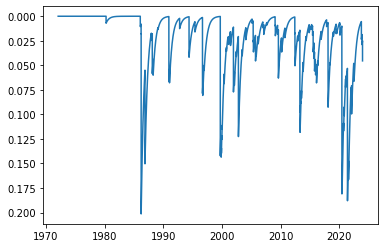

In [39]:
#Plot the time series with inverted y axis
import matplotlib.pyplot as plt
plt.plot(df1['Date '],df1['Rg'])
plt.gca().invert_yaxis()
plt.show()
